In [17]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
import qiskit as qiskit
import qiskit.quantum_info as qi
# Tomography functions
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix

from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import *

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

ibmqfactory.load_account:WARNING:2021-12-15 14:52:59,599: Credentials are already in use. The existing account in the session will be replaced.


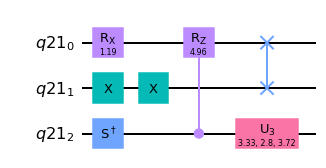

In [18]:
from qiskit.circuit.library.standard_gates import CRZGate
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)
circuit.rx(1.19, 0)
circuit.x(1)
circuit.sdg(2)
circuit.x(1)
circuit.crz(4.96,2,0)
circuit.swap(0,1)
circuit.u3(3.33,2.8,3.72,2)
circuit.draw(output='mpl')

In [1]:
vector = qi.Statevector.from_instruction(circuit)
tomo_circuit = state_tomography_circuits(circuit, circuit.qubits);

NameError: name 'qi' is not defined

In [26]:
#Simulator
name = 'ibmq_jakarta'
results = []
backend = provider.get_backend(name)
noise_model = NoiseModel.from_backend(backend)
full_layout = [0, 1, 3, 5, 4, 2, 6]
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
qcomp = Aer.get_backend("qasm_simulator")
layout = full_layout[:circuit.num_qubits]
result = qiskit.execute(tomo_circuit, Aer.get_backend('qasm_simulator'),
                                  coupling_map=coupling_map,
                                  basis_gates=basis_gates,
                                  noise_model=noise_model, initial_layout=layout, shots=8000).result()


In [27]:
from Tomography import tomography

tomo_fitter_bell = StateTomographyFitter(result, tomo_circuit).fit(method='lstsq')
densitie = DensityMatrix(tomo_fitter_bell)
fidelity = tomography.calc_fidelity(DensityMatrix(tomo_fitter_bell), vector)
purity = tomography.calc_purity(DensityMatrix(tomo_fitter_bell))

print(purity,fidelity)

(0.7897008100844404-2.392789951689929e-19j) 0.7800128834629995


In [37]:
from numpy.linalg import linalg

fixed_purities = 0

# Extracting the density matrix from the state tomography result
state_vector = qi.Statevector.from_instruction(circuit)
theo_matrix = DensityMatrix(state_vector)
theo_eig = linalg.eig(theo_matrix.data)
theo_eig = (theo_eig[0], theo_eig[1].T)

# Getting the most significant eigenvalue and eigenvector
max_val_theo = 0
index = 0
i = 0
for val in theo_eig[0]:
    if np.absolute(val) > np.absolute(max_val_theo):
        index = i
        max_val_theo = val
    i += 1
theo_vector = theo_eig[1][index]

# Real Vector
real_matrix = densitie
real_eig = np.linalg.eig(real_matrix)
real_eig = (real_eig[0], real_eig[1].T)

# Getting the most significant eigenvalue and eigenvector
max_val_real = 0
index = 0
i = 0
for val in real_eig[0]:
    if np.absolute(val) > np.absolute(max_val_real):
        index = i
        max_val_real = val
    i += 1
real_vector = real_eig[1][index]
real_eignval = real_eig[0][index]


dot = np.abs(np.vdot(theo_vector, real_vector))**2
print("Number of qubits: ", 3)
print("Vector dot: ", dot)
print("Eigenvalue", real_eignval)
print("Purity: ", np.absolute(purity))
print("Fidelity: ", np.absolute(fidelity))

print("___")
fixed_purity = np.absolute(purity) * (dot**2)
print("Fixed purity: ", fixed_purity)
print("_____________")

Number of qubits:  3
Vector dot:  0.9972966513449288
Eigenvalue (0.8854232926299483-9.256993519542396e-18j)
Purity:  0.7897008100844404
Fidelity:  0.7800128834629995
___
Fixed purity:  0.7854369080464528
_____________


In [29]:
vector.draw('latex')

<IPython.core.display.Latex object>

In [36]:
for i in range(len(real_eig[0])):
    print(np.abs(real_eig[0][i]), ": ", real_eig[1][i])

0.8854232926299483 :  [ 0.08071335+0.01412821j -0.00257408-0.00112249j  0.01351707-0.05174036j
  0.00254409-0.00535942j  0.84659118+0.j          0.01246096+0.0051408j
  0.02354296-0.52234499j  0.00561773-0.00737855j]
0.06804620647667578 :  [-0.04505793-0.01769884j  0.0359423 -0.05520721j  0.11685469+0.07291826j
 -0.01129011-0.0240951j  -0.01634914-0.52304485j  0.0159605 -0.01416181j
  0.83555646+0.j          0.03049169+0.01593343j]
0.03105031116104431 :  [ 0.85070422+0.j          0.02838857-0.00999623j -0.04104197-0.49456402j
 -0.02652481-0.0281932j  -0.06092451-0.02472543j  0.02856871+0.01413338j
  0.07779162+0.08580186j -0.03857705-0.08590291j]
0.010877580522325703 :  [-0.04618759+0.11469959j  0.11388282-0.02439695j -0.19456457+0.06723176j
 -0.00291338-0.00979864j -0.01610278+0.00287783j  0.8702487 +0.j
  0.0073846 -0.01537645j -0.00527184-0.41321554j]
0.003542503607312471 :  [ 0.33199653+0.13837709j -0.22025518+0.01527481j -0.28610617+0.53091163j
 -0.10104122-0.12312124j -0.0301252 

In [32]:
densitie.draw('latex')

<IPython.core.display.Latex object>

In [33]:
theo_matrix.draw('latex')

<IPython.core.display.Latex object>

In [ ]:
sum = 0
for i, j in zip(range(densitie.dim),range(densitie.dim)):
    sum += (densitie.data[i,j] - theo_matrix.data[i,j])**2

print("Distance: ", sum)